In [1]:
# unet_all_variants.py
# FULL UNET ASSIGNMENT IMPLEMENTATION (4 VARIANTS)
# Image size: 128x128

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import numpy as np
from tqdm import tqdm

In [2]:
# ---------------------------------------
# SECTION 1 – DATASET LOADER
# ---------------------------------------

class OxfordPetsSegmentation(OxfordIIITPet):
    """Wrapper for Oxford-IIIT Pet Dataset with binary segmentation masks"""
    def __init__(self, root='./data', split='trainval', size=128, download=True):
        self.size = size
        super().__init__(
            root=root,
            split=split,
            target_types='segmentation',
            download=download
        )

        self.img_transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.PILToTensor(),
        ])

    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)

        # Apply transforms
        img = self.img_transform(img)
        mask = self.mask_transform(mask)

        # Convert trimap to binary: 1=foreground, 2=boundary, 3=background
        # We'll treat foreground+boundary as positive (pet) vs background
        mask = (mask <= 2).float()  # 1 for pet (including boundary), 0 for background

        return img, mask


In [3]:

# ---------------------------------------
# SECTION 2 – CONTRACTING BLOCKS
# ---------------------------------------

class ContractingBlockMP(nn.Module):
    """MaxPool version"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        skip = x
        x = self.maxpool(x)
        return x, skip

class ContractingBlockStrided(nn.Module):
    """Strided Conv instead of pool"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)
        self.down = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        skip = x
        x = self.down(x)
        return x, skip

In [4]:
class ExpandingBlockTranspose(nn.Module):
    """Transposed Convolution upsampling"""
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        # in_ch: channels of x before upsample
        # skip_ch: channels in skip connection
        # out_ch: channels after this block
        self.upsample = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        # after upsample: out_ch; after concat: out_ch + skip_ch
        self.conv1 = nn.Conv2d(out_ch + skip_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x


class ExpandingBlockUpsample(nn.Module):
    """Nearest neighbor upsampling + convs"""
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        # after upsample: in_ch; after concat: in_ch + skip_ch
        self.conv1 = nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x


In [5]:
# tmp = ExpandingBlockTranspose(512, 512)
# print(tmp.upsample)  # should show ConvTranspose2d(512, 256, 2, 2)


In [6]:
class UNet(nn.Module):
    def __init__(self, contracting, expanding, in_channels=3, out_channels=1):
        super().__init__()
        # Encoder
        self.contract1 = contracting(in_channels, 64)   # out + skip1: 64
        self.contract2 = contracting(64, 128)          # out + skip2: 128
        self.contract3 = contracting(128, 256)         # out + skip3: 256

        # Decoder (mirror encoder, no extra bottleneck)
        # x after encoder: 16x16, 256ch
        self.expand1 = expanding(in_ch=256, skip_ch=256, out_ch=256)  # -> 32x32, 256
        self.expand2 = expanding(in_ch=256, skip_ch=128, out_ch=128)  # -> 64x64, 128
        self.expand3 = expanding(in_ch=128, skip_ch=64,  out_ch=64)   # -> 128x128, 64

        self.final_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x, skip1 = self.contract1(x)  # 64x64, 64ch
        x, skip2 = self.contract2(x)  # 32x32, 128ch
        x, skip3 = self.contract3(x)  # 16x16, 256ch

        x = self.expand1(x, skip3)    # 32x32, 256ch
        x = self.expand2(x, skip2)    # 64x64, 128ch
        x = self.expand3(x, skip1)    # 128x128, 64ch

        return torch.sigmoid(self.final_conv(x))


In [7]:
# ---------------------------------------
# SECTION 5 – LOSS FUNCTIONS
# ---------------------------------------

def bce_loss(pred, target):
    return nn.BCELoss()(pred, target)

def dice_loss(pred, target):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    smooth = 1e-6
    intersection = (pred * target).sum()
    return 1 - ((2 * intersection + smooth) /
                (pred.sum() + target.sum() + smooth))

In [8]:
def dice_score(pred, target, smooth=1e-6):
    # pred, target: [B, 1, H, W]
    pred_bin = (pred > 0.5).float()
    target = target.float()
    intersection = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean().item()


In [9]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs):
    best_val_dice = 0.0

    for epoch in range(epochs):
        # ----- TRAIN -----
        model.train()
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for img, mask in progress_bar:
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            pred = model(img)
            loss = loss_fn(pred, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})

        avg_train_loss = total_loss / len(train_loader)

        # ----- VALIDATION -----
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                val_loss += loss_fn(pred, mask).item()
                val_dice += dice_score(pred, mask)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice

        print(f"Epoch {epoch+1}/{epochs}: "
              f"TrainLoss={avg_train_loss:.4f} | "
              f"ValLoss={avg_val_loss:.4f} | "
              f"ValDice={avg_val_dice:.4f}")

    return best_val_dice


In [11]:
# ---------------------------------------
# SECTION 7 – MAIN EXECUTION (RUN ALL 4 MODELS)
# ---------------------------------------

if __name__ == "__main__":
    # Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        # Set paths in Google Drive
        drive_root = '/content/drive/MyDrive/ERAV4/Session_15'
        import os
        os.makedirs(drive_root, exist_ok=True)
        os.chdir(drive_root)

        data_path = os.path.join(drive_root, 'data')
        print(f"✓ Google Drive mounted")
        print(f"✓ Working directory: {drive_root}")
        print(f"✓ Dataset will be saved to: {data_path}\n")
    except Exception:
        # Running locally or Drive mount failed
        data_path = './data'
        print("Running without Google Drive mount (local or Drive unavailable)\n")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}\n")

    # Load dataset using torchvision
    print("Loading Oxford-IIIT Pet Dataset...")
    print("(First run will download ~800MB - this may take a few minutes)")
    dataset = OxfordPetsSegmentation(root=data_path,
                                     split='trainval',
                                     size=128,
                                     download=True)
    print(f"✓ Dataset loaded: {len(dataset)} images\n")

    # Train/val split
    from torch.utils.data import random_split, DataLoader

    n_total = len(dataset)
    n_val = int(0.1 * n_total)
    n_train = n_total - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

    # Verification prints
    print("✓ Dataset processed successfully!")
    print(f"  - Train samples: {len(train_ds)}")
    print(f"  - Val samples:   {len(val_ds)}")
    print(f"  - First image shape: {dataset[0][0].shape}")
    print(f"  - First mask shape:  {dataset[0][1].shape}\n")

    # Define all 4 configurations
    configs = [
        ("MP+Tr+BCE",
         ContractingBlockMP,      ExpandingBlockTranspose, bce_loss),
        ("MP+Tr+Dice",
         ContractingBlockMP,      ExpandingBlockTranspose, dice_loss),
        ("StrConv+Tr+BCE",
         ContractingBlockStrided, ExpandingBlockTranspose, bce_loss),
        ("StrConv+Ups+Dice",
         ContractingBlockStrided, ExpandingBlockUpsample,  dice_loss),
    ]

    # Train all 4 variants
    results = []
    for idx, (name, cblock, eblock, loss_fn) in enumerate(configs, 1):
        print(f"\n{'='*60}")
        print(f"Training Model {idx}/4: {name}")
        print(f"{'='*60}")

        model = UNet(cblock, eblock).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        best_val_dice = train_model(
            model,
            train_loader,
            val_loader,
            optimizer,
            loss_fn,
            device,
            epochs=10
        )

        # Save model
        model_path = f"{name.replace('+', '_').replace(' ', '')}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"  ✓ Model saved: {model_path}")

        results.append((name, best_val_dice))

    # Print summary
    print(f"\n{'='*60}")
    print("TRAINING SUMMARY - ALL 4 MODELS COMPLETED")
    print(f"{'='*60}")
    for name, val_dice in results:
        print(f"{name:20s} - Best Val Dice: {val_dice:.4f}")
    print(f"{'='*60}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Working directory: /content/drive/MyDrive/ERAV4/Session_15
✓ Dataset will be saved to: /content/drive/MyDrive/ERAV4/Session_15/data

Using device: cuda

Loading Oxford-IIIT Pet Dataset...
(First run will download ~800MB - this may take a few minutes)
✓ Dataset loaded: 3680 images

✓ Dataset processed successfully!
  - Train samples: 3312
  - Val samples:   368
  - First image shape: torch.Size([3, 128, 128])
  - First mask shape:  torch.Size([1, 128, 128])


Training Model 1/4: MP+Tr+BCE


Epoch 1/10: TrainLoss=0.3377 | ValLoss=0.2886 | ValDice=0.9423


Epoch 2/10: TrainLoss=0.2525 | ValLoss=0.2456 | ValDice=0.9460


Epoch 3/10: TrainLoss=0.2236 | ValLoss=0.2251 | ValDice=0.9504


Epoch 4/10: TrainLoss=0.2083 | ValLoss=0.2194 | ValDice=0.9511


Epoch 5/10: TrainLoss=0.1971 | ValLoss=0.2074 | ValDice=0.9525


Epoch 6/10: TrainLoss=0.1897 | ValLoss=0.2022 | ValDice=0.9541


Epoch 7/10: TrainLoss=0.1821 | ValLoss=0.2044 | ValDice=0.9535


Epoch 8/10: TrainLoss=0.1760 | ValLoss=0.1998 | ValDice=0.9541


Epoch 9/10: TrainLoss=0.1691 | ValLoss=0.1978 | ValDice=0.9553


Epoch 10/10: TrainLoss=0.1626 | ValLoss=0.2091 | ValDice=0.9543
  ✓ Model saved: MP_Tr_BCE.pth

Training Model 2/4: MP+Tr+Dice


Epoch 1/10: TrainLoss=0.1948 | ValLoss=0.1455 | ValDice=0.9398


Epoch 2/10: TrainLoss=0.1225 | ValLoss=0.1052 | ValDice=0.9426


Epoch 3/10: TrainLoss=0.0903 | ValLoss=0.0807 | ValDice=0.9458


Epoch 4/10: TrainLoss=0.0726 | ValLoss=0.0683 | ValDice=0.9482


Epoch 5/10: TrainLoss=0.0623 | ValLoss=0.0615 | ValDice=0.9491


Epoch 6/10: TrainLoss=0.0562 | ValLoss=0.0562 | ValDice=0.9510


Epoch 7/10: TrainLoss=0.0519 | ValLoss=0.0527 | ValDice=0.9523


Epoch 8/10: TrainLoss=0.0489 | ValLoss=0.0511 | ValDice=0.9524


Epoch 9/10: TrainLoss=0.0466 | ValLoss=0.0503 | ValDice=0.9524


Epoch 10/10: TrainLoss=0.0448 | ValLoss=0.0484 | ValDice=0.9536
  ✓ Model saved: MP_Tr_Dice.pth

Training Model 3/4: StrConv+Tr+BCE


Epoch 1/10: TrainLoss=0.4257 | ValLoss=0.3428 | ValDice=0.9376


Epoch 2/10: TrainLoss=0.3035 | ValLoss=0.2883 | ValDice=0.9436


Epoch 3/10: TrainLoss=0.2565 | ValLoss=0.2472 | ValDice=0.9471


Epoch 4/10: TrainLoss=0.2303 | ValLoss=0.2300 | ValDice=0.9508


Epoch 5/10: TrainLoss=0.2121 | ValLoss=0.2150 | ValDice=0.9520


Epoch 6/10: TrainLoss=0.2012 | ValLoss=0.2186 | ValDice=0.9519


Epoch 7/10: TrainLoss=0.1928 | ValLoss=0.2057 | ValDice=0.9532


Epoch 8/10: TrainLoss=0.1858 | ValLoss=0.2061 | ValDice=0.9541


Epoch 9/10: TrainLoss=0.1799 | ValLoss=0.2041 | ValDice=0.9541


Epoch 10/10: TrainLoss=0.1743 | ValLoss=0.1948 | ValDice=0.9553
  ✓ Model saved: StrConv_Tr_BCE.pth

Training Model 4/4: StrConv+Ups+Dice


Epoch 1/10: TrainLoss=0.1513 | ValLoss=0.1221 | ValDice=0.9411


Epoch 2/10: TrainLoss=0.0987 | ValLoss=0.0852 | ValDice=0.9431


Epoch 3/10: TrainLoss=0.0774 | ValLoss=0.0726 | ValDice=0.9445


Epoch 4/10: TrainLoss=0.0654 | ValLoss=0.0644 | ValDice=0.9466


Epoch 5/10: TrainLoss=0.0578 | ValLoss=0.0590 | ValDice=0.9476


Epoch 6/10: TrainLoss=0.0531 | ValLoss=0.0535 | ValDice=0.9505


Epoch 7/10: TrainLoss=0.0499 | ValLoss=0.0513 | ValDice=0.9516


Epoch 8/10: TrainLoss=0.0478 | ValLoss=0.0502 | ValDice=0.9518


Epoch 9/10: TrainLoss=0.0460 | ValLoss=0.0496 | ValDice=0.9519


Epoch 10/10: TrainLoss=0.0443 | ValLoss=0.0469 | ValDice=0.9541
  ✓ Model saved: StrConv_Ups_Dice.pth

TRAINING SUMMARY - ALL 4 MODELS COMPLETED
MP+Tr+BCE            - Best Val Dice: 0.9553
MP+Tr+Dice           - Best Val Dice: 0.9536
StrConv+Tr+BCE       - Best Val Dice: 0.9553
StrConv+Ups+Dice     - Best Val Dice: 0.9541


In [12]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os

# ---------------------------------------
# VISUALIZATION FUNCTIONS
# ---------------------------------------

def visualize_predictions(model, dataset, device, num_samples=8, save_path=None):
    """
    Visualize model predictions vs ground truth

    Args:
        model: Trained UNet model
        dataset: Dataset to sample from
        device: cuda/cpu
        num_samples: Number of samples to visualize
        save_path: Path to save figure (optional)
    """
    model.eval()

    # Create figure with subplots
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            # Get random sample
            idx = np.random.randint(0, len(dataset))
            img, mask = dataset[idx]

            # Get prediction
            img_input = img.unsqueeze(0).to(device)
            pred = model(img_input).cpu().squeeze()

            # Convert to numpy for plotting
            img_np = img.permute(1, 2, 0).numpy()
            mask_np = mask.squeeze().numpy()
            pred_np = pred.numpy()
            pred_binary = (pred_np > 0.5).astype(np.float32)

            # Plot
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title(f'Prediction (raw)')
            axes[i, 2].axis('off')

            axes[i, 3].imshow(pred_binary, cmap='gray')
            axes[i, 3].set_title('Prediction (thresh>0.5)')
            axes[i, 3].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Visualization saved to: {save_path}")

    plt.show()


def visualize_overlay(model, dataset, device, num_samples=6, save_path=None):
    """
    Visualize predictions overlaid on original images
    Shows where model is correct (green), incorrect (red)
    """
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            img, mask = dataset[idx]

            # Get prediction
            img_input = img.unsqueeze(0).to(device)
            pred = model(img_input).cpu().squeeze()
            pred_binary = (pred > 0.5).float()

            # Convert to numpy
            img_np = img.permute(1, 2, 0).numpy()
            mask_np = mask.squeeze().numpy()
            pred_np = pred_binary.numpy()

            # Create overlay visualization
            overlay = np.zeros((*img_np.shape[:2], 3))

            # True Positives (Green) - correctly predicted foreground
            tp = (pred_np == 1) & (mask_np == 1)
            overlay[tp] = [0, 1, 0]

            # False Positives (Red) - incorrectly predicted foreground
            fp = (pred_np == 1) & (mask_np == 0)
            overlay[fp] = [1, 0, 0]

            # False Negatives (Blue) - missed foreground
            fn = (pred_np == 0) & (mask_np == 1)
            overlay[fn] = [0, 0, 1]

            # Blend overlay with image
            blended = img_np * 0.6 + overlay * 0.4

            # Plot
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(np.clip(blended, 0, 1))
            axes[i, 2].set_title('Overlay (Green=TP, Red=FP, Blue=FN)')
            axes[i, 2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Overlay visualization saved to: {save_path}")

    plt.show()


def test_on_single_image(model, image_path, device, size=128):
    """
    Test model on a single image (without ground truth)

    Args:
        model: Trained model
        image_path: Path to test image
        device: cuda/cpu
        size: Image size for model input
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor).cpu().squeeze()

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    img_np = img_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
    pred_np = pred.numpy()
    pred_binary = (pred_np > 0.5).astype(np.float32)

    axes[0].imshow(img_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(pred_np, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Prediction (raw probabilities)')
    axes[1].axis('off')

    axes[2].imshow(pred_binary, cmap='gray')
    axes[2].set_title('Binary Mask (threshold=0.5)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def compare_all_models(models_dict, dataset, device, num_samples=4, save_path=None):
    """
    Compare predictions from all 4 model variants side by side

    Args:
        models_dict: Dict of {'model_name': model} for all variants
        dataset: Dataset to sample from
        device: cuda/cpu
        num_samples: Number of samples to compare
        save_path: Path to save comparison figure
    """
    num_models = len(models_dict)

    fig, axes = plt.subplots(num_samples, num_models + 2,
                            figsize=(3*(num_models+2), 4*num_samples))

    # Set all models to eval mode
    for model in models_dict.values():
        model.eval()

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            img, mask = dataset[idx]

            img_input = img.unsqueeze(0).to(device)
            img_np = img.permute(1, 2, 0).numpy()
            mask_np = mask.squeeze().numpy()

            # Plot input and ground truth
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title('Input')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            # Plot predictions from each model
            for j, (name, model) in enumerate(models_dict.items()):
                pred = model(img_input).cpu().squeeze()
                pred_binary = (pred > 0.5).float().numpy()

                axes[i, j+2].imshow(pred_binary, cmap='gray')
                axes[i, j+2].set_title(name)
                axes[i, j+2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Model comparison saved to: {save_path}")

    plt.show()


def compute_detailed_metrics(model, dataloader, device):
    """
    Compute detailed metrics on validation set

    Returns dict with IoU, Dice, Precision, Recall, Accuracy
    """
    model.eval()

    total_iou = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    total_accuracy = 0
    count = 0

    with torch.no_grad():
        for img, mask in dataloader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            pred_binary = (pred > 0.5).float()

            # Flatten for metric computation
            pred_flat = pred_binary.view(-1)
            mask_flat = mask.view(-1)

            # Compute metrics
            tp = (pred_flat * mask_flat).sum()
            fp = (pred_flat * (1 - mask_flat)).sum()
            fn = ((1 - pred_flat) * mask_flat).sum()
            tn = ((1 - pred_flat) * (1 - mask_flat)).sum()

            # IoU
            iou = tp / (tp + fp + fn + 1e-6)

            # Dice
            dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)

            # Precision
            precision = tp / (tp + fp + 1e-6)

            # Recall
            recall = tp / (tp + fn + 1e-6)

            # Accuracy
            accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)

            total_iou += iou.item()
            total_dice += dice.item()
            total_precision += precision.item()
            total_recall += recall.item()
            total_accuracy += accuracy.item()
            count += 1

    return {
        'IoU': total_iou / count,
        'Dice': total_dice / count,
        'Precision': total_precision / count,
        'Recall': total_recall / count,
        'Accuracy': total_accuracy / count
    }

VISUAL EVALUATION OF UNET PREDICTIONS

1. Generating prediction grid...
✓ Visualization saved to: predictions_grid.png


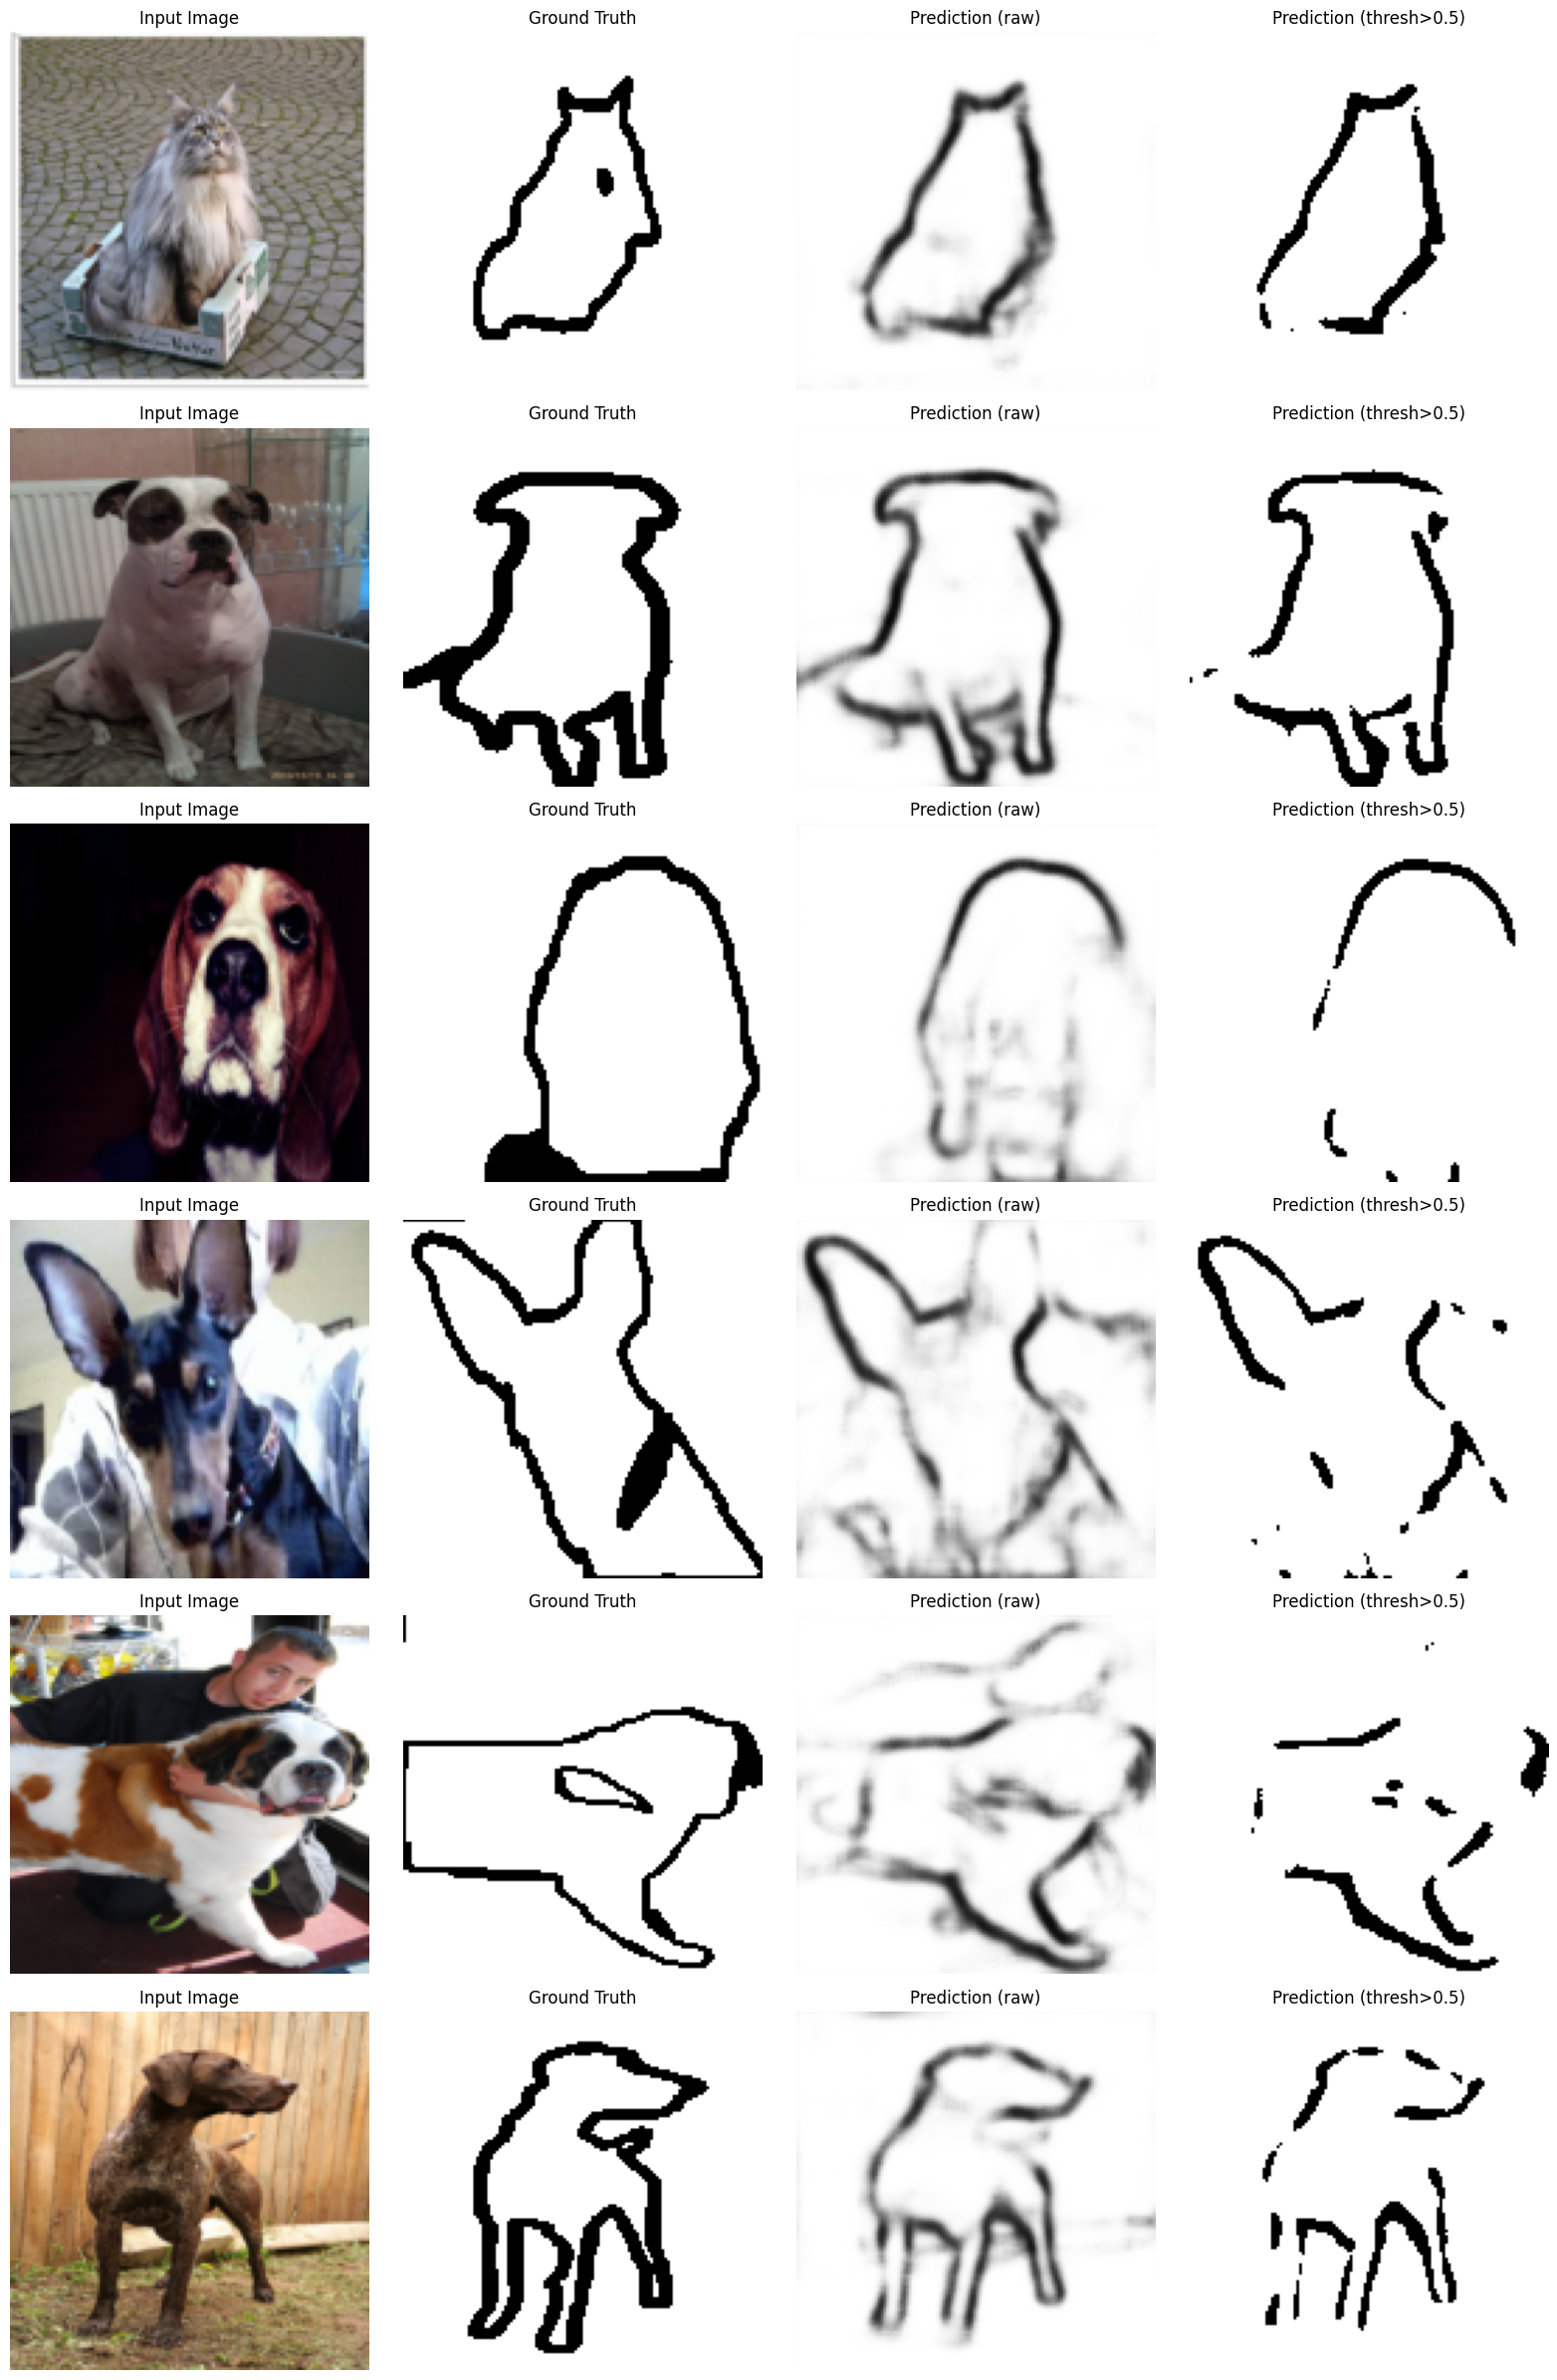


2. Generating overlay visualization...
✓ Overlay visualization saved to: predictions_overlay.png


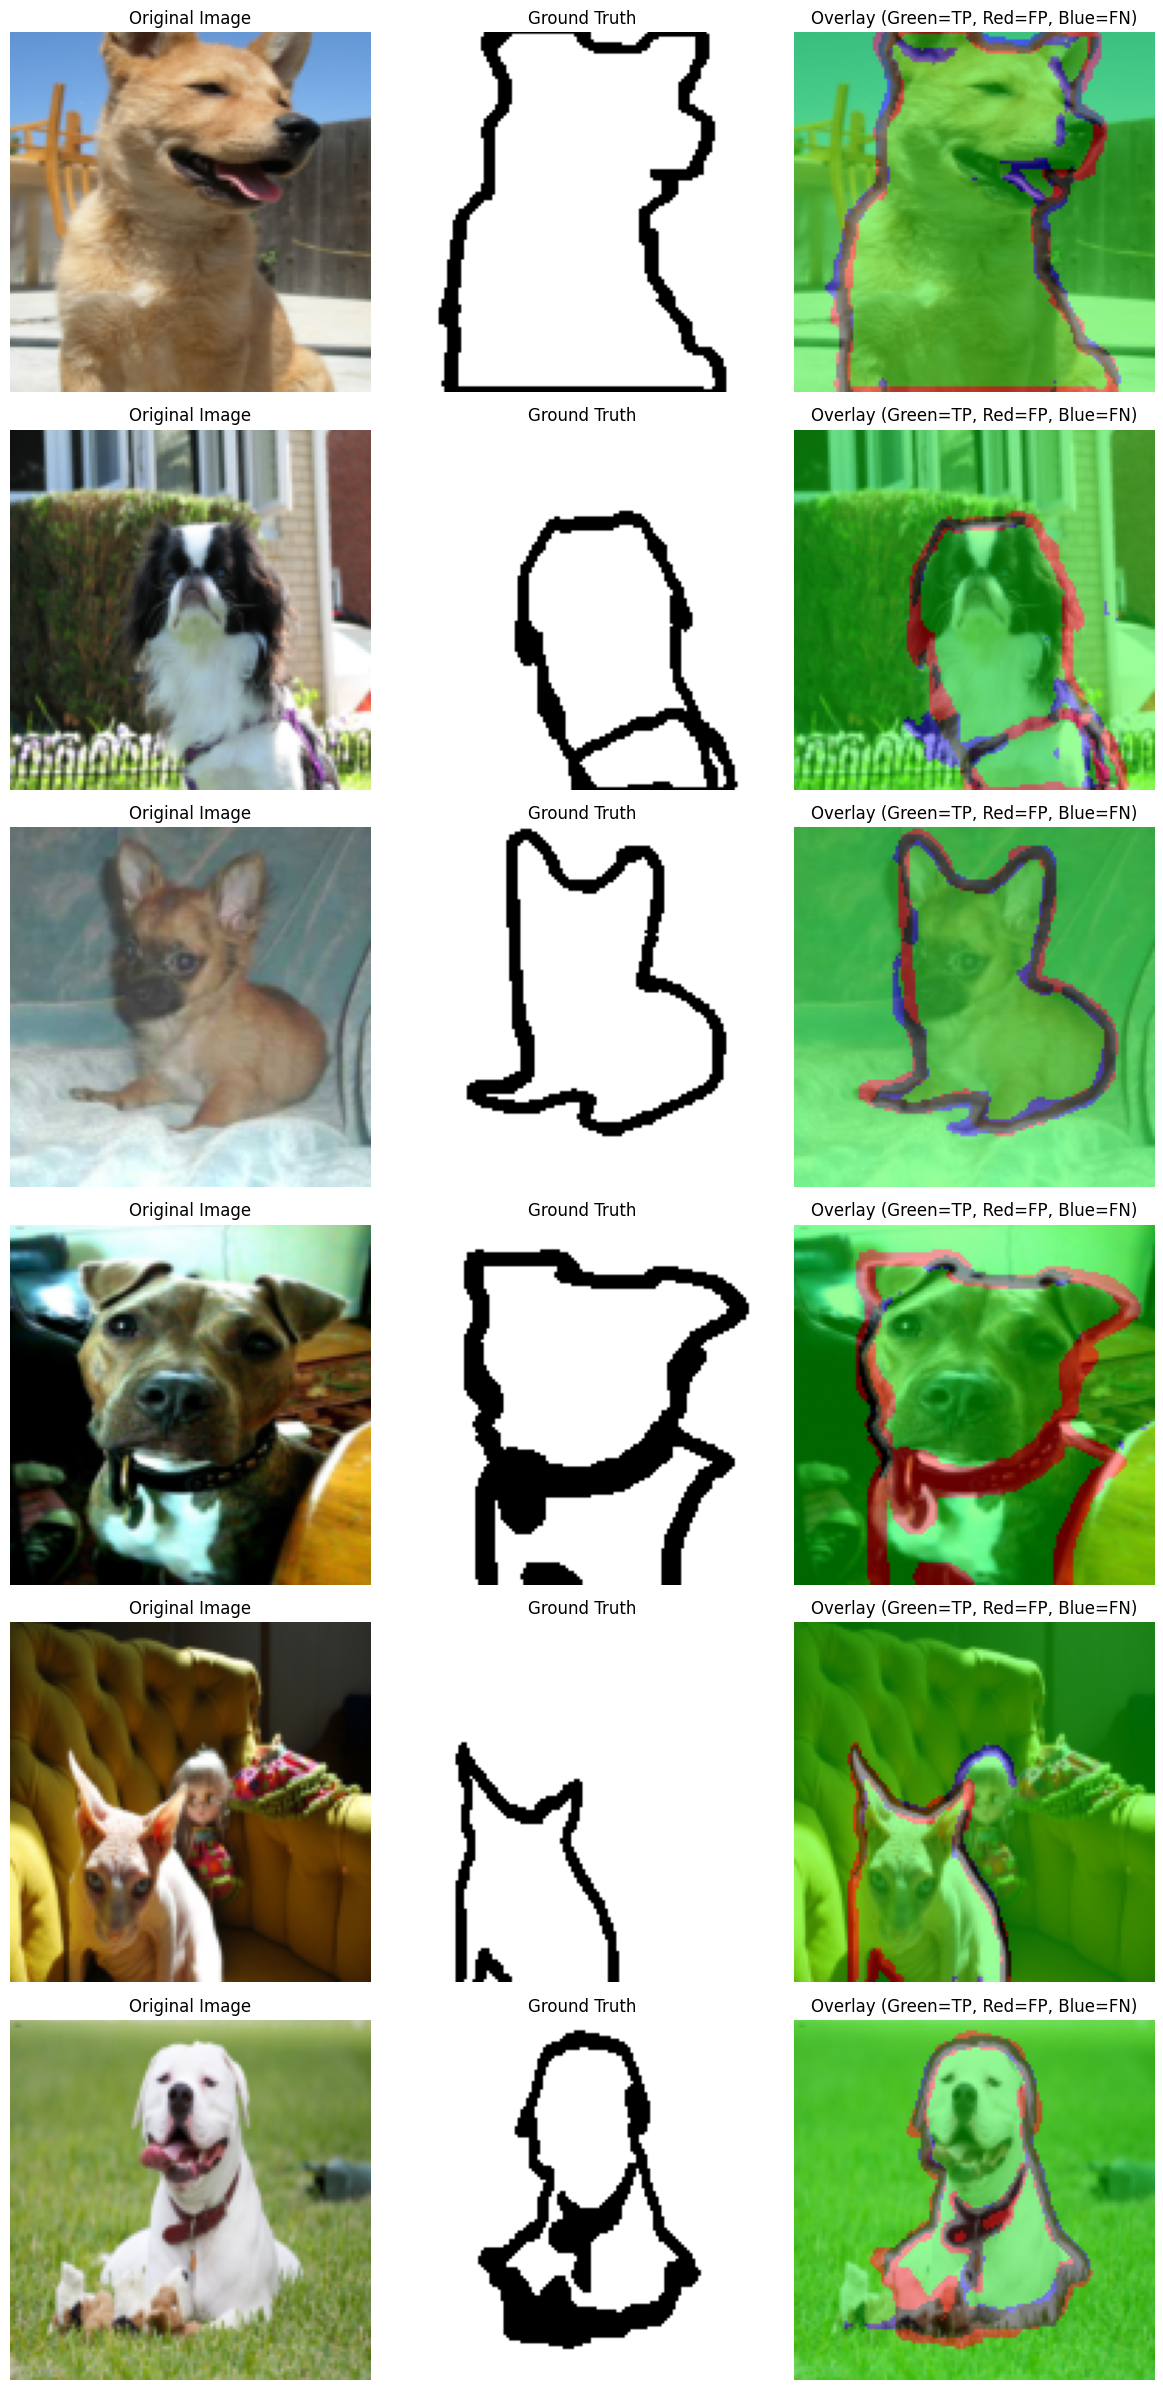


3. Testing on single image...

4. Comparing all models...

5. Computing detailed metrics...

Detailed Metrics:
  IoU:       0.9271
  Dice:      0.9622
  Precision: 0.9463
  Recall:    0.9787
  Accuracy:  0.9314

Visual evaluation complete!


In [14]:

# ---------------------------------------
# USAGE EXAMPLE
# ---------------------------------------

if __name__ == "__main__":
    """
    Example usage after training your models
    """

    # Setup (adjust paths as needed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Import your dataset and model classes
    # from bikash_unet_training import (
    #     OxfordPetsSegmentation,
    #     UNet,
    #     ContractingBlockMP,
    #     ExpandingBlockTranspose
    # )

    # Load dataset
    dataset = OxfordPetsSegmentation(root='./data', split='trainval', size=128)

    # Load a trained model (example with one model)
    model = UNet(ContractingBlockMP, ExpandingBlockTranspose).to(device)
    model.load_state_dict(torch.load('MP_Tr_BCE.pth', map_location=device))

    print("="*60)
    print("VISUAL EVALUATION OF UNET PREDICTIONS")
    print("="*60)

    # 1. Basic prediction visualization
    print("\n1. Generating prediction grid...")
    visualize_predictions(model, dataset, device, num_samples=6,
                         save_path='predictions_grid.png')

    # 2. Overlay visualization (shows errors)
    print("\n2. Generating overlay visualization...")
    visualize_overlay(model, dataset, device, num_samples=6,
                     save_path='predictions_overlay.png')

    # 3. Test on single image
    print("\n3. Testing on single image...")
    # test_on_single_image(model, 'path/to/your/test_image.jpg', device)

    # 4. Compare all 4 models (if you have them trained)
    print("\n4. Comparing all models...")
    """
    models_dict = {
        'MP+Tr+BCE': model1,
        'MP+Tr+Dice': model2,
        'StrConv+Tr+BCE': model3,
        'StrConv+Ups+Dice': model4
    }
    compare_all_models(models_dict, dataset, device, num_samples=4,
                      save_path='model_comparison.png')
    """

    # 5. Compute detailed metrics
    print("\n5. Computing detailed metrics...")
    from torch.utils.data import DataLoader
    val_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    metrics = compute_detailed_metrics(model, val_loader, device)

    print("\nDetailed Metrics:")
    print(f"  IoU:       {metrics['IoU']:.4f}")
    print(f"  Dice:      {metrics['Dice']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")

    print("\n" + "="*60)
    print("Visual evaluation complete!")
    print("="*60)